# Orchestration: Agents and Tool Use

This notebook was created by Natasha Patnaik for MIT 15.S60 - Computing in Optimization and Statistics. 

**Last Updated**: January 2026.

This notebook demonstrates:
- LangGraph as a stateful orchestration layer (nodes, edges, conditional routing, loops) for building an agentic workflow.
- Tool use (e.g., Wikipedia search, a free and convenient API) as an essential feature of agentic systems.
- A ReAct agent loop (Thought - Action - Observation) with explicit traces.
- Using different LLMs for different roles in the loop.

See https://arxiv.org/abs/2210.03629 for the original paper on ReAct.

**Scenario**: A travel agent that can research info to build a customized itinerary.


In [1]:
import json
from pathlib import Path
from typing import TypedDict, List, Dict, Any, Optional
import re

from langchain_ollama import ChatOllama
from ollama import chat
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, END

# For Wikipedia search
WIKI_API = "https://en.wikipedia.org/w/api.php"

import os
import requests
from dotenv import load_dotenv
load_dotenv()

# Check that you've set the environment variables correctly
YOUR_EMAIL = os.getenv("YOUR_EMAIL")
print("YOUR_EMAIL:", YOUR_EMAIL)

c:\Users\npatn\OneDrive\Documents\15.S60_2026\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1
c:\Users\npatn\OneDrive\Documents\15.S60_2026\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


YOUR_EMAIL: natashap@mit.edu


## LLM prerequisites

We're going to use different LLMs for different roles. Feel free to change the configuration here, just make sure you've pulled any Ollama models before you run them, or have a valid Open AI API key.

In [2]:
!ollama pull llama3.1:8b
print("Pulled llama3.1:8b")

Pulled llama3.1:8b


pulling manifest ⠋ pulling manifest ⠙ pulling manifest 
pulling 667b0c1932bc: 100% ▕██████████████████▏ 4.9 GB                         
pulling 948af2743fc7: 100% ▕██████████████████▏ 1.5 KB                         
pulling 0ba8f0e314b4: 100% ▕██████████████████▏  12 KB                         
pulling 56bb8bd477a5: 100% ▕██████████████████▏   96 B                         
pulling 455f34728c9b: 100% ▕██████████████████▏  487 B                         
verifying sha256 digest 
writing manifest 
success 


In [3]:
!ollama pull qwen3:8b
print("Pulled qwen3:8b")

Pulled qwen3:8b


pulling manifest ⠋ pulling manifest ⠙ pulling manifest 
pulling a3de86cd1c13: 100% ▕██████████████████▏ 5.2 GB                         
pulling ae370d884f10: 100% ▕██████████████████▏ 1.7 KB                         
pulling d18a5cc71b84: 100% ▕██████████████████▏  11 KB                         
pulling cff3f395ef37: 100% ▕██████████████████▏  120 B                         
pulling 05a61d37b084: 100% ▕██████████████████▏  487 B                         
verifying sha256 digest 
writing manifest 
success 


In [4]:
# Check what models are available locally
!ollama list

NAME           ID              SIZE      MODIFIED               
llama3.1:8b    46e0c10c039e    4.9 GB    Less than a second ago    
qwen3:8b       500a1f067a9f    5.2 GB    Less than a second ago    
mistral:7b     6577803aa9a0    4.4 GB    7 days ago                
gemma3:1b      8648f39daa8f    815 MB    9 days ago                


In [5]:
# Sepearate models for ReAct framework and writing/ planning the itinerary
MODEL_PLANNER = "llama3.1:8b"        
planner_llm = ChatOllama(model=MODEL_PLANNER, temperature=0.2) # Some creativity with high temp

def routing_llm(system_text: str, user_text: str, model: str = "qwen3:8b") -> tuple[str, str]:
    """
    Call Ollama directly with think=True so we can log the model's 'thinking' as the ReAct Thought trace.
    """
    resp = chat(
        model=model,
        messages=[
            {"role": "system", "content": system_text},
            {"role": "user", "content": user_text},
        ],
        think=True,
        stream=False,
    )
    thinking = (getattr(resp.message, "thinking", "") or "").strip()
    content = (resp.message.content or "").strip()
    return thinking, content



## PART A: Define Tools

We'll define separate functions for each tool we want our agent to have access to. This encapsulates logic for each task in one place, and can be re-used throughout with a standardized format.

### Web search tool (Wikipedia API for Demonstration Purposes)

We'll implement a web search function, using the official Wikipedia API (you can swap this out for an actual search engine API to get better results, if you'd like).

In [6]:
def web_search(query: str, max_results: int = 5, max_chars: int = 8000) -> dict:
    """
    Web search via Wikipedia MediaWiki API.

    For each result:
      - Searches Wikipedia for relevant pages
      - Downloads the full page (plain text)
      - Truncates to `max_chars` to fit in LLM context

    Returns:
      {"query": str, "results": [{"title","url","content"}]}
    """

    # HTTP headers
    # Wikimedia asks for a descriptive User-Agent with a way to contact you.
    headers = {
        "User-Agent": f"LLM-Workshop/0.1 (contact: {YOUR_EMAIL})",
        "Accept": "application/json",
    }

    # This helps us view where we are within our ReAct loop.
    print(f"[Wikipedia] query='{query}'")

    # First, we'll look for relevant wikipedia pages
    search_params = {
        "action": "query",
        "list": "search", # MediaWiki's search endpoint for retrieving page titles
        "srsearch": query,
        "srlimit": max_results,
        "format": "json",
    }

    # We use the requests library to make HTTP requests in Python
    r = requests.get(url=WIKI_API, params=search_params, headers=headers, timeout=20)
    r.raise_for_status()  # Raise an exception for HTTP errors
    data = r.json()    # Parse the JSON response into a Python dict

    results = []

    # Then, for each search result, get the full page content
    for item in data["query"]["search"]:
        title = item["title"]

        page_params = {
            "action": "query",
            "prop": "extracts",     # get article content
            "explaintext": True,    # return full article as plain text
            "titles": title,
            "format": "json",
        }

        r2 = requests.get(WIKI_API, params=page_params, headers=headers, timeout=20)
        r2.raise_for_status()
        page_data = r2.json()

        # MediaWiki returns pages as a dict keyed by page ID.
        # We take the first (and usually only) page in the response.
        pages = page_data["query"]["pages"]
        page = next(iter(pages.values()))
        full_text = page.get("extract", "")

        # Clean excessive whitespace with regex
        full_text = re.sub(r"\n{3,}", "\n\n", full_text).strip()

        # Hard cap to avoid exceeding the LLM context window
        # (important when this text is later inserted into a prompt)
        truncated = full_text[:max_chars]

        results.append({
            "title": title,
            "url": f"https://en.wikipedia.org/wiki/{title.replace(' ', '_')}",
            "content": truncated,
        })

    return {"query": query, "results": results}


In [7]:
# Check that the web_search function works
searches = web_search("Tourist attractions in Boston", max_results=3)
for result in searches["results"]:
    print("Title:", result["title"])
    print("URL:", result["url"])
    print("Content snippet:", result["content"][:300], "...\n")

[Wikipedia] query='Tourist attractions in Boston'
Title: List of tourist attractions in Boston
URL: https://en.wikipedia.org/wiki/List_of_tourist_attractions_in_Boston
Content snippet: The following is a list of tourist attractions in Boston, Massachusetts. Some sites appear in multiple lists.

== Historic sites and national parks ==

Black Heritage Trail
Boston Harbor Islands National Recreation Area
Boston National Historical Park
Castle Island
Custom House Tower
Dorchester Heig ...

Title: Tourist attractions in the United States
URL: https://en.wikipedia.org/wiki/Tourist_attractions_in_the_United_States
Content snippet: This is a list of the most popular individual tourist attractions in the United States, lists of tourist attractions organized by subject region, and a selection of other notable tourist attractions and destinations.
Times Square is the most visited public (not privately owned) tourist site in the U ...

Title: Irish Heritage Trail
URL: https://en.wikipedia.org/wiki

### Wiki extract tool

If there's a specific Wikipedia page we are already interested in, we can just return the introduction section (extract) for that page. This is a more targeted tool.

In [8]:
def wiki_page_extract(title: str, max_chars: int = 6000) -> dict:
    """
    Get the full plaintext intro section (extract) for a specific Wikipedia page title.
    """
    headers = {
        "User-Agent": f"LLM-Workshop/0.1 (contact: {YOUR_EMAIL})",
        "Accept": "application/json",
    }

    page_params = {
        "action": "query",
        "prop": "extracts",
        "explaintext": True,
        "titles": title,
        "format": "json",
        "redirects": 1,  # follow redirects (e.g., "NYC" -> "New York City")
    }

    r = requests.get(WIKI_API, params=page_params, headers=headers, timeout=20)
    r.raise_for_status()
    
    page_data = r.json()
    pages = page_data["query"]["pages"]
    page = next(iter(pages.values()))

    full_text = page.get("extract", "")
    full_text = re.sub(r"\n{3,}", "\n\n", full_text).strip()

    return {
        "title": page.get("title", title),
        "url": f"https://en.wikipedia.org/wiki/{(page.get('title', title)).replace(' ', '_')}",
        "content": full_text[:max_chars],
    }

In [9]:
# Check that the wiki_page_extract function works
page = wiki_page_extract("Boston", max_chars=2000)
print("Title:", page["title"])
print("URL:", page["url"])  
print("Content snippet:", page["content"][:300], "...\n")

Title: Boston
URL: https://en.wikipedia.org/wiki/Boston
Content snippet: Boston is the capital and most populous city of the U.S. state of Massachusetts. It serves as the cultural and financial center of New England, a region of the Northeastern United States. Boston has an area of 48.4 mi2 (125 km2) and a population of 675,647 as of the 2020 census, making it the third- ...



## PART B: Orchestration via LangGraph

This code defines the workflow/ sequence of events through which the agent operates.

In LangGraph, the system is defined in terms of nodes. Each node executes a specific behavior and encapsulates a single step of the process. Nodes are connected to each other by edges, and the resultant graph defines the permissible sequence of events our agent can take.

For our travel agent's workflow, we'll define the following nodes:

* ``router_node`` = decides the next control action to take based on the observed state
* ``research_node`` = executes the wikipedia tools (web search and page extract) to look up information
* ``clarify_node`` = asks the user a follow-up question to discern preferences
* ``plan_node`` = use the reasoning trace and collected context to generate an appropriate travel itinerary

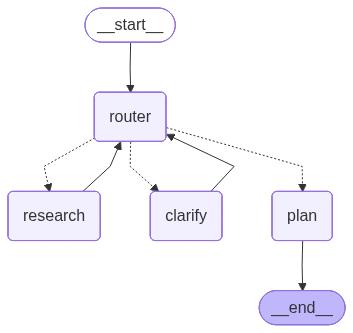

### LangGraph State

LangGraph passes a mutable `state` through the nodes as the sequence progresses, We'll keep the state explicit so you can see what information is being stored and why.

Key fields:
- user_request: the input task
- research_notes: accumulated tool outputs
- itinerary: the current plan
- react_trace: Thought/Action/Observation logs for transparency/debugging


In [10]:
class TravelAgentState(TypedDict, total=False):
    """
    Structured state for the Travel Agent application.
    Fields are filled as the agent progresses.
    """
    react_steps: int              # track how many ReAct iterations have run
    max_react_steps: int          # configurable limit
    forced_plan: bool             # whether to force planning step in order to terminate within limit

    user_request: str
    destination: str
    dates: str
    budget: str

    research_notes: List[Dict[str, Any]]
    itinerary: str

    react_trace:  List[str]             # trace entries in thought-action-observation format
    next_step: str                      # used for routing

    # Optional: router can set these
    clarify_question: str
    research_query: str
    did_required_research: bool # Look up the destination once confirmed

def add_trace(state: TravelAgentState, thought: str, action: str, observation: str) -> None:
    """
    Helper to add a ReAct trace entry to the state.
    """
    state.setdefault("react_trace", [])
    state["react_trace"].append(f"Thought: {thought}\nAction: {action}\nObservation: {observation}")

### Router Node

We use an LLM for routing, which reasons on what the next step should be:
- "research" if we need wikipedia info 
- "plan" if we have enough info to build an itinerary
- "clarify" if the best course of action is to ask a follow-up question

This demonstrates conditional edges.


In [11]:
def router_node(state: TravelAgentState) -> TravelAgentState:
    """
    Router\controller node for a ReAct-style travel agent.

    Responsibilities:
      - inspects the current agent state
      - decides what the next action should be
      - enforces hard constraints (termination, required info, one-time tools)
      - prevents infinite loops and tool abuse
    """
    
    print("Routing next step...")

    # Initialize state defaults
    state["react_steps"] = state.get("react_steps", 0)
    state["max_react_steps"] = state.get("max_react_steps", 20)
    state["forced_plan"] = state.get("forced_plan", False)
    state.setdefault("research_notes", [])
    state.setdefault("react_trace", [])

    # Update key fields with user input
    req = state["user_request"]
    destination = (state.get("destination") or "").strip()
    dates = (state.get("dates") or "").strip()
    budget = (state.get("budget") or "").strip()
    notes = state.get("research_notes", [])

    # Hard stop: force final itinerary planning if max steps reached
    if state["react_steps"] >= state["max_react_steps"]:
        print("Forcing agent to return itinerary")
        state["forced_plan"] = True
        state["next_step"] = "plan"
        add_trace(
            state,
            thought=f"Reached max steps ({state['max_react_steps']}); must terminate with a best-effort plan.",
            action="route -> plan",
            observation="Forced termination: generating itinerary now."
        )
        return state

    # Increment step counter once per router decision
    state["react_steps"] += 1

    # Ensure we have critical slots filled... 
    missing = []
    if not destination:
        missing.append("destination (specific city + country/state)")
    if not dates:
        missing.append("dates (month, season, or exact dates)")

    # ... If critical slots missing, MUST clarify (no guessing).
    if missing:
        print("Missing info: ask question to user to clarify")
        question = (
            "Before I can produce a specific day-by-day itinerary, I need: "
            + ", ".join(missing)
            + ".\n"
            "Please reply with a specific destination and date window."
        )
        state["clarify_question"] = question
        state["next_step"] = "clarify"
        add_trace(
            state,
            thought=f"Required information missing ({', '.join(missing)}); planning now would be guesswork.",
            action="route -> clarify",
            observation=f"Asked user: {question}"
        )
        return state
    
    # Force ONE deterministic destination lookup (fun facts) after the destination is confirmed
    if destination and (not state["did_required_research"]) and (not state.get("forced_plan", False)):
        state["research_query"] = (
            f"{destination} travel overview main attractions neighborhoods transportation safety"
        )
        state["next_step"] = "research"
        state["research_query"] = f"PAGE::{destination}" 
        state["did_required_research"] = True
        
        add_trace(
            state,
            thought="Destination is confirmed - search Wikipedia page to find fun facts for the itinerary.",
            action=f"route -> research (wiki_page_extract title={destination!r})",
            observation="Forced one-time destination page lookup."
        )
        return state

    # Provide compact state to router LLM
    last_notes = notes[-5:]  # keep short
    context_blob = {
        "destination": destination,
        "dates": dates,
        "budget": budget,
        "recipients": state.get("recipients"),
        "num_research_notes": len(notes),
        "last_research_notes": last_notes,
        "forced_plan": state.get("forced_plan", False),
    }

    # Count recent tool errors to avoid endless retry loops
    recent_errors = sum(1 for n in notes[-3:] if isinstance(n, dict) and "error" in n)

    # Track whether any tool has successfully returned output 
    has_any_tool_obs = any(isinstance(n, dict) and n.get("tool") == "web_search" and "output" in n for n in notes)

    system_text = (
        "You are the controller for a travel-agent system.\n"
        "Choose the next step: research | clarify | plan\n\n"
        "Rules:\n"
        "- Do NOT invent a destination or dates; if missing, choose clarify.\n"
        "- Choose research if we don't have any fun facts about the destination.\n"
        "- Avoid repeating the same research. If research is failing (tool errors), stop researching.\n"
        "- Choose plan if you have enough to draft a concrete itinerary.\n"
        "Return exactly one token: research | clarify | plan"
    )

    user_text = (
        f"USER REQUEST:\n{req}\n\n"
        f"CURRENT STATE (summary):\n{json.dumps(context_blob, indent=2)}\n\n"
        f"RECENT SIGNALS:\n"
        f"- recent_tool_errors_last5: {recent_errors}\n"
        f"- has_any_tool_observation: {has_any_tool_obs}\n"
    )

    thinking, decision = routing_llm(system_text, user_text, model="qwen3:8b")
    decision = decision.strip().lower()

    # Defensive fallback in case model returns illegal decision
    if decision not in {"research", "plan", "clarify"}:
        decision = "research"

    # If tools have been erroring repeatedly, override research -> plan (unless clarify is needed)
    if decision == "research" and recent_errors >= 3 and not state.get("forced_plan", False):
        decision = "plan"

     # If research: generate a targeted query
    if decision == "research":
        rq_system = (
            "Write ONE targeted Wikipedia search query that helps plan the trip by looking up fun facts about the city.\n"
            "The query must mention the destination and relevant constraints (dates/season/budget/interests).\n"
            "Return only the query string."
        )
        rq_user = f"Request: {req}\nState: {json.dumps(context_blob)}"
        rq_thinking, rq = routing_llm(rq_system, rq_user, model="qwen3:8b")
        rq = rq.strip()
        state["research_query"] = rq

        add_trace(
            state,
            thought=rq_thinking or "Decide next step.",
            action=f"route -> research (research_query={rq!r})",
            observation="Router selected research and produced a targeted query."
        )
        state["next_step"] = "research"
        return state

    # If clarify: set a single concrete clarify_question for follow-up
    if decision == "clarify":
        cq_system = (
            "Write ONE concise follow-up question that asks the user for their trip preferences.\n"
            "Ask for a concrete opinion or constraint. Do not ask multiple questions.\n"
            "Return only the question text."
        )
        cq_user = f"Request: {req}\nState: {json.dumps(context_blob)}"
        cq_thinking, cq = routing_llm(cq_system, cq_user, model="qwen3:8b")
        cq = cq.strip()
        state["clarify_question"] = cq

        add_trace(
            state,
            thought=cq_thinking or "Decide next step.",
            action="route -> clarify",
            observation=f"Router selected clarify. Question: {cq}"
        )
        state["next_step"] = "clarify"
        return state

    # Finally, time to plan itinerary!
    add_trace(
        state,
        thought=thinking or "Decide next step.",
        action="route -> plan",
        observation="Router selected plan; proceed to itinerary generation."
    )
    state["next_step"] = "plan"
    return state


<>:3: SyntaxWarning: "\c" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\c"? A raw string is also an option.
<>:3: SyntaxWarning: "\c" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\c"? A raw string is also an option.
C:\Users\npatn\AppData\Local\Temp\ipykernel_25024\623237128.py:3: SyntaxWarning: "\c" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\c"? A raw string is also an option.
  Router\controller node for a ReAct-style travel agent.


### Research Node

In [12]:
def research_node(state: TravelAgentState) -> TravelAgentState:
    """
    Research node for the travel agent.

    Responsibilities:
      - Execute Wikipedia-backed retrieval tools
      - Record tool outputs and errors in state["research_notes"]
      - Avoid redundant searches
      - Always return control back to the router
    """
    print("[ACTION] Searching Wikipedia...")

    dest = state.get("destination", "the destination")
    notes = state.get("research_notes", [])
    state.setdefault("react_trace", [])

    # If router provided a specific query, use it
    router_query = state.get("research_query")

    if router_query.startswith("PAGE::"):
        title = router_query.replace("PAGE::", "", 1).strip() or dest
        try:
            page = wiki_page_extract(title, max_chars=6000)
            notes.append({"tool": "wiki_page_extract", "input": title, "output": page})

            add_trace(
                state,
                thought=f"Search Wikipedia for fun facts on {dest} to help make the itinerary.",
                action=f"wiki_page_extract(title={title!r})",
                observation=f"Fetched Wikipedia page '{page.get('title')}'."
            )
        except Exception as e:
            notes.append({"tool": "wiki_page_extract", "input": title, "error": str(e)})
            add_trace(
                state,
                thought=f"Need fun facts for {dest}.",
                action=f"wiki_page_extract(title={title!r})",
                observation=f"Tool error: {e}"
            )

        state["research_notes"] = notes
        state["next_step"] = "router"
        return state

    # Store queries already asked to avoid repetition
    # If no specific query, use default ones
    if router_query:
        queries = [router_query]
    else:
        queries = [
            f"Tourist attractions in {dest}",
        ]

    # For extra safety: avoid repeating the same searches
    already_searched = {n.get("input") for n in notes if n.get("tool") == "web_search"}

    # Execute web_search for each query
    for q in queries:
        # Skip queries we've already executed
        if q in already_searched:
            add_trace(
                state,
                thought=f"Skip repeated query to avoid redundant research.",
                action=f"web_search(query={q!r})", #repr for the query instead of string
                observation="Skipped (duplicate query already executed)."
            )
            continue

        try:
            # Run the web search tool
            res = web_search(q, max_results=1)
            # Store successful output
            notes.append({"tool": "web_search", "input": q, "output": res})

            # Count returned results (defensive check)
            n_results = len(res.get("results", [])) if isinstance(res, dict) else 0
            add_trace(
                state,
                thought=f"Need external facts to support itinerary decisions for {dest}.",
                action=f"web_search(query={q!r}, max_results=3)",
                observation=f"Retrieved {n_results} results."
            )
        except Exception as e:
            # Capture tool failure for the router to reason about
            notes.append({"tool": "web_search", "input": q, "error": str(e)})
            add_trace(
                state,
                thought=f"Need external facts to support itinerary decisions for {dest}.",
                action=f"web_search(query={q!r}, max_results=3)",
                observation=f"Tool error: {e}"
            )

    # Update state and return to router
    state["research_notes"] = notes
    state["next_step"] = "router"
    
    return state


### Clarify Node

In [13]:
def clarify_node(state: TravelAgentState) -> TravelAgentState:
    """
    Human-in-the-loop clarification node.

    Responsibilities:
      - Ask the user a follow-up question chosen by the router (state["clarify_question"])
      - Capture the user's response
      - Store the response in state for future reasoning
    """
    state.setdefault("research_notes", [])
    state.setdefault("react_trace", [])

    question = (state.get("clarify_question") or "").strip()

    # If router forgot to set question, fail gracefully and return to router.
    if not question:
        add_trace(
            state,
            thought="Need clarification but router did not provide a question.",
            action="ask_user(<missing clarify_question>)",
            observation="No question asked; returning to router."
        )
        state["next_step"] = "router"
        return state

    print("Clarification needed:")
    print(question)
    user_answer = input("\nYour answer: ").strip()

    state["research_notes"].append({
        "source": "user",
        "question": question,
        "answer": user_answer,
    })

    add_trace(
        state,
        thought="Missing information preventing itinerary planning - ask the user directly.",
        action=f"ask_user({question!r})",
        observation=f"User answered: {user_answer}"
    )

    # Optional: update structured fields when obvious
    q_lower = question.lower()
    if "budget" in q_lower and user_answer:
        state["budget"] = user_answer
    if ("date" in q_lower or "when" in q_lower) and user_answer:
        state["dates"] = user_answer
    if "destination" in q_lower and user_answer:
        state["destination"] = user_answer

    # Go back to controller
    state["next_step"] = "router"
    
    return state


### Plan Node

In [14]:
def plan_node(state: TravelAgentState) -> TravelAgentState:
    """
    Planning node for the travel agent.

    Responsibilities:
      - Synthesize a final itinerary from the accumulated research notes
      - Ground recommendations in retrieved facts when available
      - Produce the terminal output of the agent workflow
    """
    print("Planning itinerary...")

    # Original user request (natural language)
    req = state["user_request"]

    # All accumulated research notes from previous tool calls
    notes = state.get("research_notes", [])

    # This flag is used to decide whether we need to warn the user
    # that the itinerary is best-effort rather than fact-grounded.
    has_tool_obs = any(n.get("tool") == "web_search" and "output" in n for n in notes)

    # If not grounded, still produce a plan but label it clearly as best-effort.
    # (Router should normally prevent entering plan without grounding.)
    grounding_banner = ""
    if not has_tool_obs and not state.get("forced_plan", False):
        grounding_banner = (
            "NOTE: I couldn't retrieve external facts about the destination. "
            "This itinerary is best-effort and may require verification.\n\n"
        )

    # Retain last few notes to stay within context window
    notes_text = json.dumps(notes[-6:], indent=2) 

    # Prompt for Planner LLM
    messages = [
        SystemMessage(content=
            "You are a travel planner. Produce a daily itinerary with:\n"
            "- some fun facts about the destination (look at research notes)\n"
            "- morning/afternoon/evening blocks\n"
            "- 2-3 concrete activity suggestions per block\n"
            "- practical tips (transport, reservations)\n"
            "- keep it concise but actionable\n"
            "Use the research notes when helpful to adhere to the user's preferences.\n"
            "When you use facts from research notes, mention them explicitly."
        ),
        HumanMessage(content=f"User request:\n{req}\n\nResearch notes:\n{notes_text}")
    ]
    
    # Generate itinerary using the planner LLM, store with grounding warning if needed
    itinerary = planner_llm.invoke(messages).content.strip()
    state["itinerary"] = grounding_banner + itinerary

    add_trace(
        state,
        thought="Sufficient information collected - synthesize a final itinerary.",
        action="generate_itinerary",
        observation="Itinerary generated; terminating."
    )

    return state


## PART C: Build the LangGraph

In [15]:
# Create a StateGraph whose nodes operate on TravelAgentState
graph = StateGraph(TravelAgentState)

# Add nodes to the graph
graph.add_node("router", router_node)
graph.add_node("research", research_node)
graph.add_node("clarify", clarify_node)
graph.add_node("plan", plan_node)

# Workflow starts with the router taking in the user's initial query
graph.set_entry_point("router") 

def route_from_router(state: TravelAgentState) -> str:
    """
    Read the router's decision from the state and return
    the name of the next node to execute.

    If the router fails to set next_step, default to 'research'
    as a safe fallback.
    """
    return state.get("next_step", "research")

# Add conditional edges:
# After the router runs, choose exactly one outgoing edge based on the string returned by route_from_router().
graph.add_conditional_edges(
    "router",
    route_from_router,
    {
        "research": "research",
        "clarify": "clarify",
        "plan": "plan",
    }
)

# After any action node, we always return to the router node
graph.add_edge("research", "router")
graph.add_edge("clarify", "router")

# The plan node produces the final output and ends the workflow.
graph.add_edge("plan", END)

# Compile into an executable application!
app = graph.compile()

<unknown>:3: SyntaxWarning: "\c" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\c"? A raw string is also an option.


In [16]:
# This generates a PNG image of the graph structure we just created!
image_data = app.get_graph().draw_mermaid_png()
with open("travel_agent_graph.png", mode="wb") as f:
    f.write(image_data)

## PART D: Run the Agent

In [17]:
initial_state: TravelAgentState = {

    # User specifications
    "max_react_steps": 10,
    "user_request": "Plan a 3-day trip",
    "destination": "Boston",
    "dates": "January",
    "budget": "cheap",

    # Internal state
    "react_steps": 0,         
    "forced_plan": False,
    "research_notes": [],
    "react_trace": [],
    "did_required_research": False,
    
}

final_state = app.invoke(initial_state)

print("\n=== FINAL ITINERARY ===\n")
print(final_state.get("itinerary", ""))

print("\n=== RESEARCH NOTES (last 3) ===\n")
for n in final_state.get("research_notes", [])[-3:]:
    # simple pretty print
    tool = n.get("tool", n.get("source", ""))
    print(f"- {tool} | input/question: {n.get('input', n.get('question', ''))}")
    if "error" in n:
        print(f"  ERROR: {n['error']}")
    else:
        # truncate tool output
        out = n.get("output", n.get("answer", ""))
        s = str(out)
        print(f"  output/answer: {s[:300]}{'...' if len(s) > 300 else ''}")

print("\n=== REACT TRACE (last 5 steps) ===\n")
for step in final_state.get("react_trace", [])[-5:]:
    print(step)
    print("-" * 60)


Routing next step...
[ACTION] Searching Wikipedia...
Routing next step...
[ACTION] Searching Wikipedia...
[Wikipedia] query='"cheap 3-day Boston trip in January: fun facts about winter activities, historic sites, and budget-friendly attractions"'
Routing next step...
Clarification needed:
What type of activities or experiences would you prioritize during your trip—historical sites, winter outdoor activities, or budget-friendly local attractions?
Routing next step...
Planning itinerary...

=== FINAL ITINERARY ===

**Day 1: Exploring Boston's Historic Sites**

* Morning (9:00 am - 12:00 pm)
	+ Visit the **Boston Common**, the oldest public park in the country, established in 1634 (free admission).
	+ Walk to the nearby **Massachusetts State House**, a stunning example of neoclassical architecture and home to the Massachusetts General Court (guided tours available for $1).
	+ Stop by the **Old State House**, a historic landmark that served as the seat of government during the American Rev